In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5


In [3]:
f(3.0)


20.0

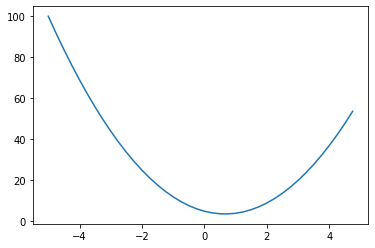

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)


In [5]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h


14.00300000000243

In [273]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        # saving the above defined _backward method in out
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self+other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)
                          ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ),  f'**{other}')

        def _backward():
            self.grad += out.grad * other * (self.data**(other-1))
        out._backward = _backward
        return out

    def __rmul__(self, other):  # other * self
        return self*other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):

        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (out.grad) * (1 - t**2)
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# (a.__mul__(b).__add__(c))


In [164]:
a = Value(2.0)
b = Value(4.0)
a - b


Value(data=-2.0)

In [57]:
from graphviz import Digraph


def trace(root):
    # build set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR letft to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (
            n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [97]:
# a.data += 0.01*a.grad
# b.data += 0.01*b.grad
# c.data += 0.01*c.grad
# f.data += 0.01*f.grad

# e = a * b
# d = e + c
# L = d * f
# print(L.data)


-7.286496


In [167]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735, label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

o.backward()


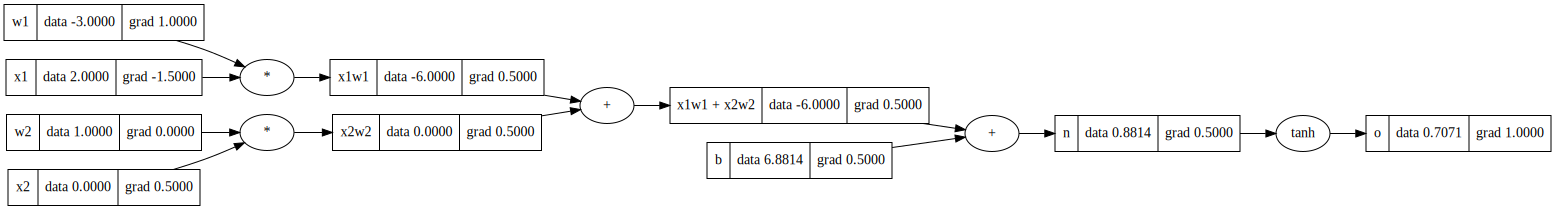

In [168]:
draw_dot(o)


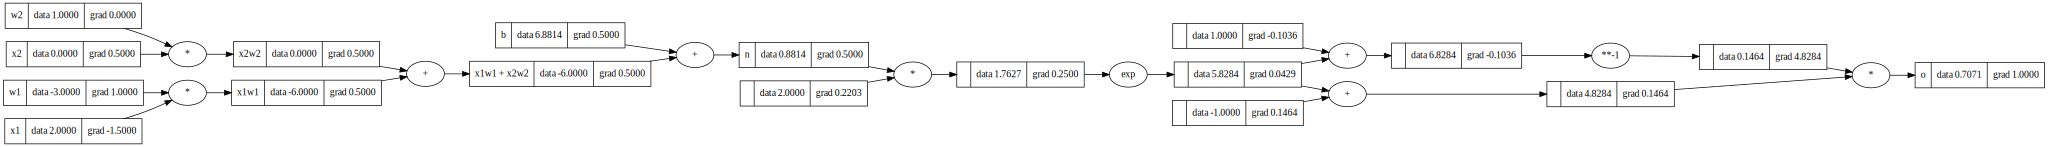

In [171]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735, label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b
n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)


In [134]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2


In [172]:
import torch
from torch.


In [177]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('____')

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
____
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [179]:
import random


In [290]:
class Neuron:

    def __init__(self, nin):
        # nin: no. of inputs, decides how may weights need to be stored in a neuron plus a base
        # weights
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        # bias
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        # nin decides number of input neurons.
        # nout decides number of neurons to created in this layer.
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params


class MLP:

    def __init__(self, nin, nouts):
        # nin is no. of input units
        # nout is list of numbers, where each number is no. of neurons, and it's index is layer number
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


Value(data=0.505223805071589)

In [349]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.8246138543151238)

In [350]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets


In [355]:
for k in range(40):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01*p.grad
    print(k, "---", loss.data)


0 --- 0.10662770838810812
1 --- 0.10396618185981057
2 --- 0.10142259981881102
3 --- 0.09898964335323049
4 --- 0.09666056872041565
5 --- 0.09442915322007361
6 --- 0.09228964695244399
7 --- 0.09023672974044111
8 --- 0.08826547259244523
9 --- 0.08637130316571368
10 --- 0.084549974761524
11 --- 0.0827975384440781
12 --- 0.08111031792744908
13 --- 0.07948488691980866
14 --- 0.07791804865289187
15 --- 0.07640681735811569
16 --- 0.0749484014797082
17 --- 0.07354018844030347
18 --- 0.07217973079626604
19 --- 0.07086473363898428
20 --- 0.06959304311493197
21 --- 0.0683626359517478
22 --- 0.06717160989025099
23 --- 0.06601817493339657
24 --- 0.06490064533292529
25 --- 0.063817432243035
26 --- 0.06276703697794825
27 --- 0.06174804481692295
28 --- 0.06075911930613882
29 --- 0.05979899701210936
30 --- 0.058866482685892785
31 --- 0.05796044480147716
32 --- 0.05707981143536461
33 --- 0.05622356645762914
34 --- 0.055390746007615385
35 --- 0.05458043523003403
36 --- 0.053791765249516066
37 --- 0.053023

In [356]:
ypred


[Value(data=0.9027565941395829),
 Value(data=-0.9413580439024476),
 Value(data=-0.860258871119479),
 Value(data=0.86170755125418)]